<a href="https://colab.research.google.com/github/sangzun-han/opencv-flattening/blob/main/crackDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


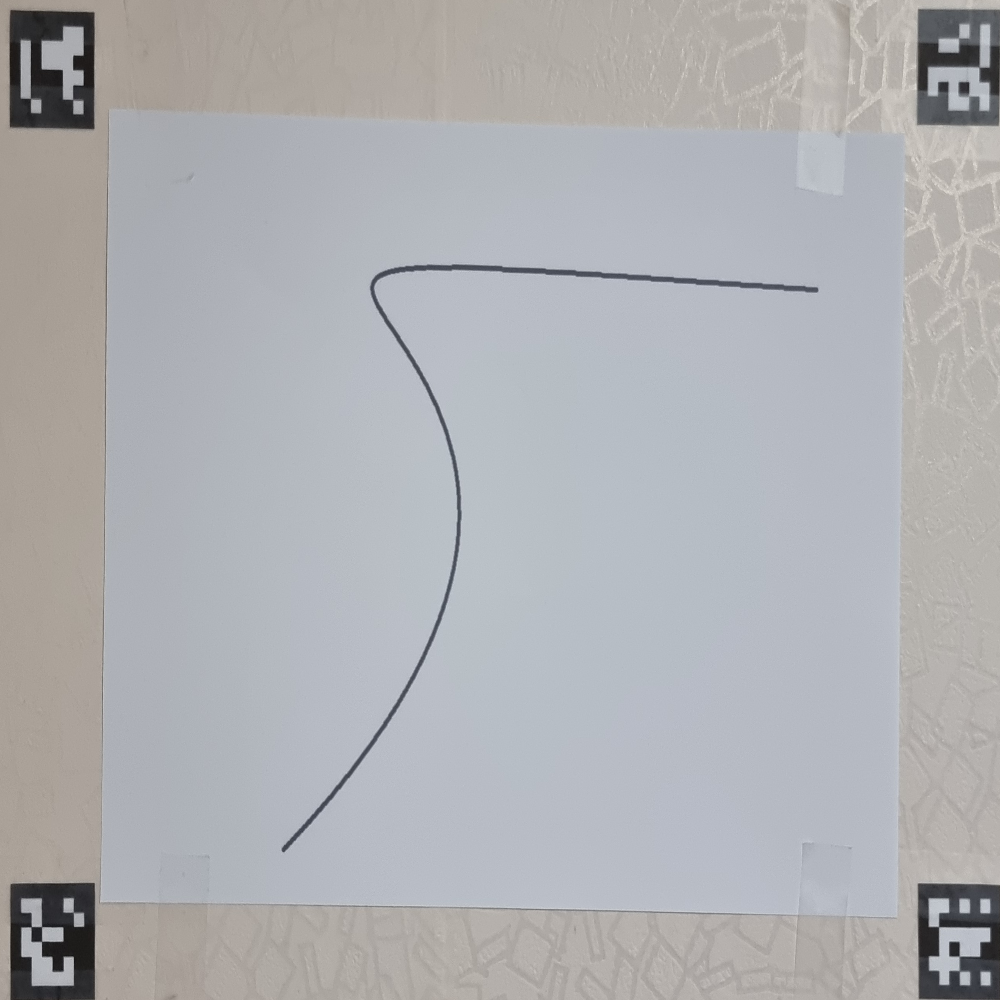

True

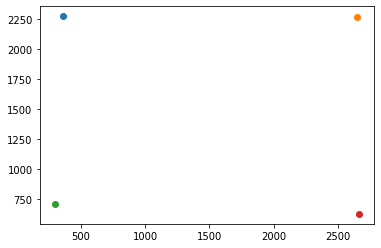

In [88]:
# 평탄화
import numpy as np
import cv2, PIL
import pandas as pd
import matplotlib as mpl
from cv2 import aruco
from PIL import Image
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

img = cv2.imread("/content/drive/MyDrive/CrackDetection/test2.png")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
frame_markers = aruco.drawDetectedMarkers(img.copy(), corners, ids)

# cv2_imshow(frame_markers)

for i in range(len(ids)):
    c = corners[i][0]
    plt.plot([c[:, 0].mean()], [c[:, 1].mean()], "o", label = "id={0}".format(ids[i]))
    if ids[i][0] == 1:
      ap = [c[0, 0], c[0, 1]]
    if ids[i][0] == 2:
      cp = [c[1, 0], c[1, 1]]
    if ids[i][0] == 3:
      bp = [c[3, 0], c[3, 1]]
    if ids[i][0] == 4:
      dp = [c[2, 0], c[2, 1]]
      

# 좌표점은 좌상->좌하->우상->우하
pts1 = np.float32([ap, bp, cp, dp])

# 좌표의 이동점
pts2 = np.float32([[10,10],[10,1000],[1000,10],[1000,1000]])

M = cv2.getPerspectiveTransform(pts1, pts2)
dst = cv2.warpPerspective(img, M, (1000,1000))

cv2_imshow(dst)
cv2.imwrite('/content/drive/MyDrive/CrackDetection/target.jpg', dst)

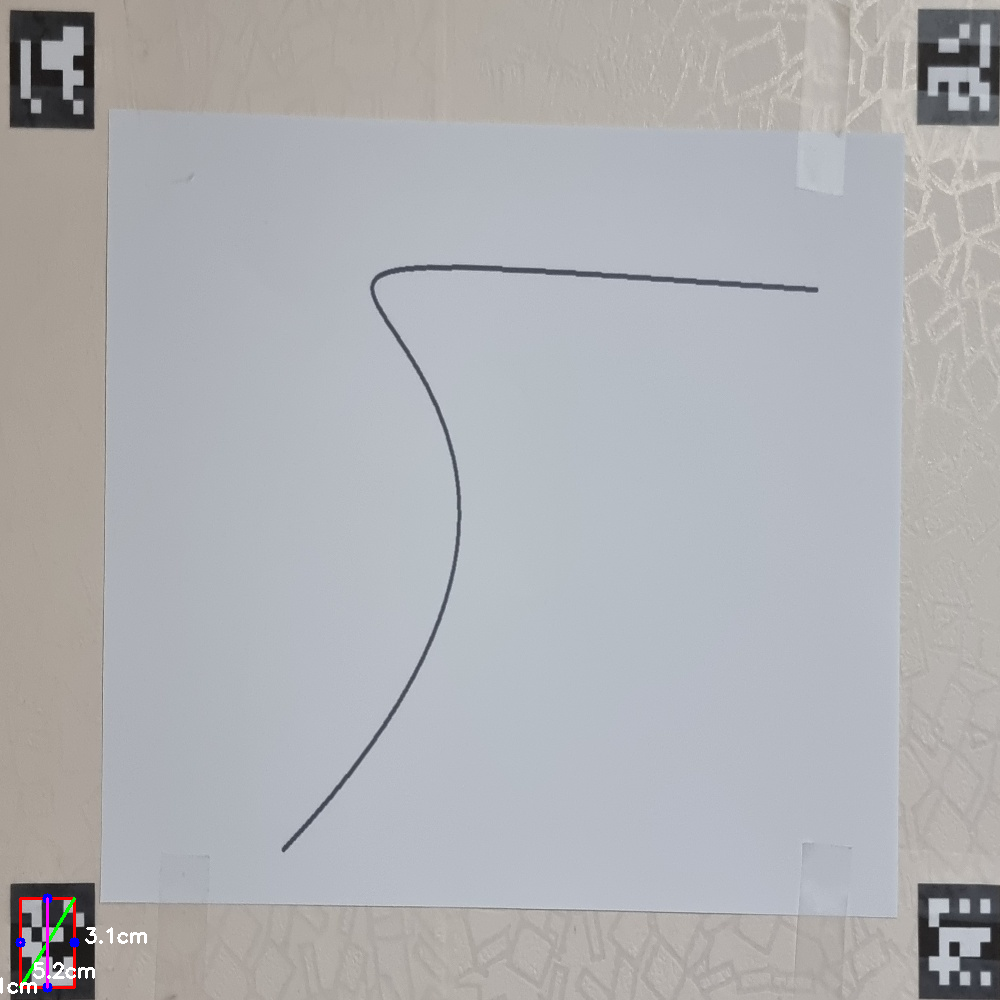

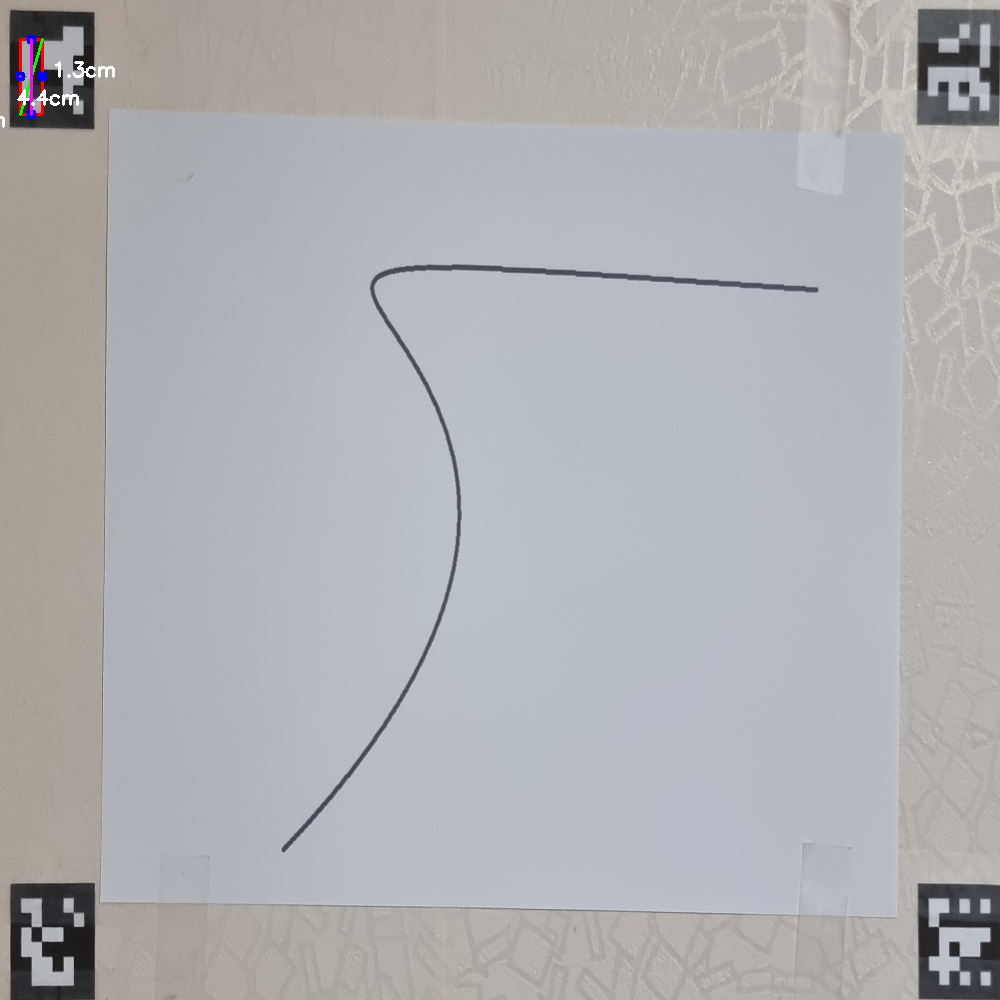

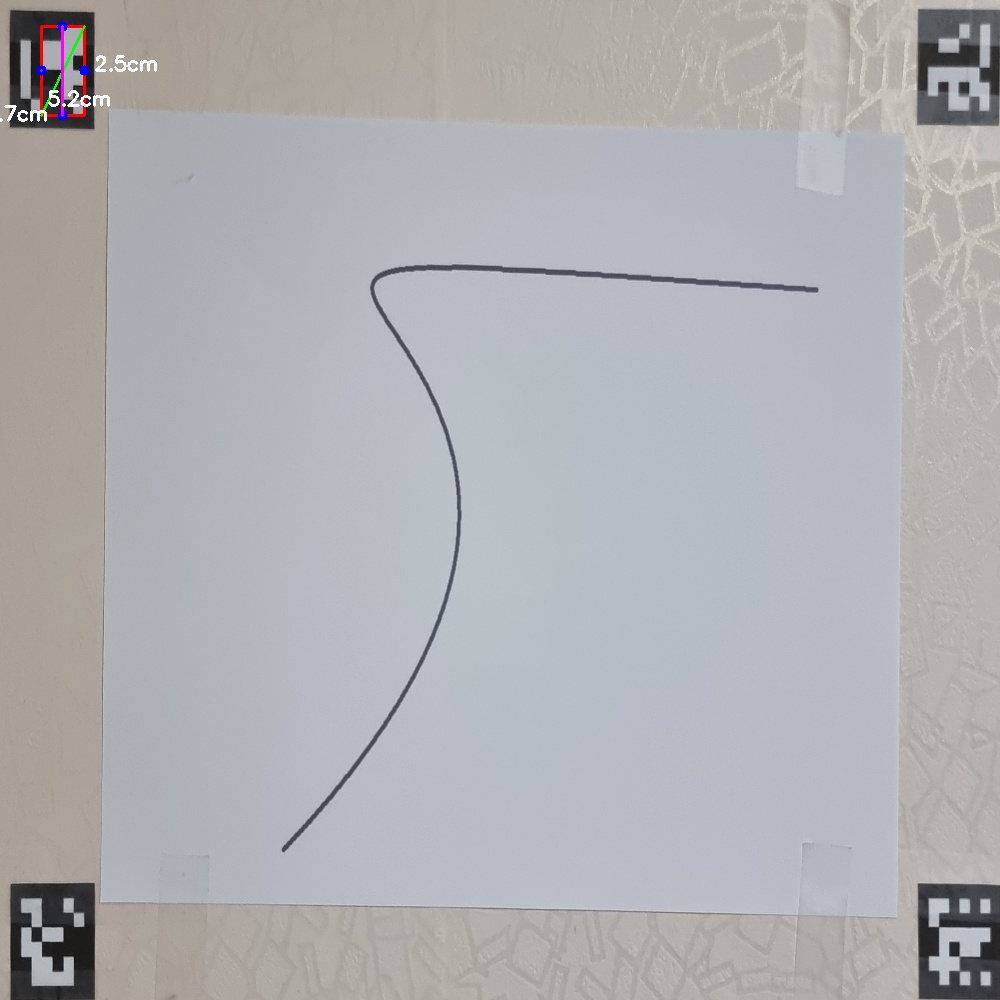

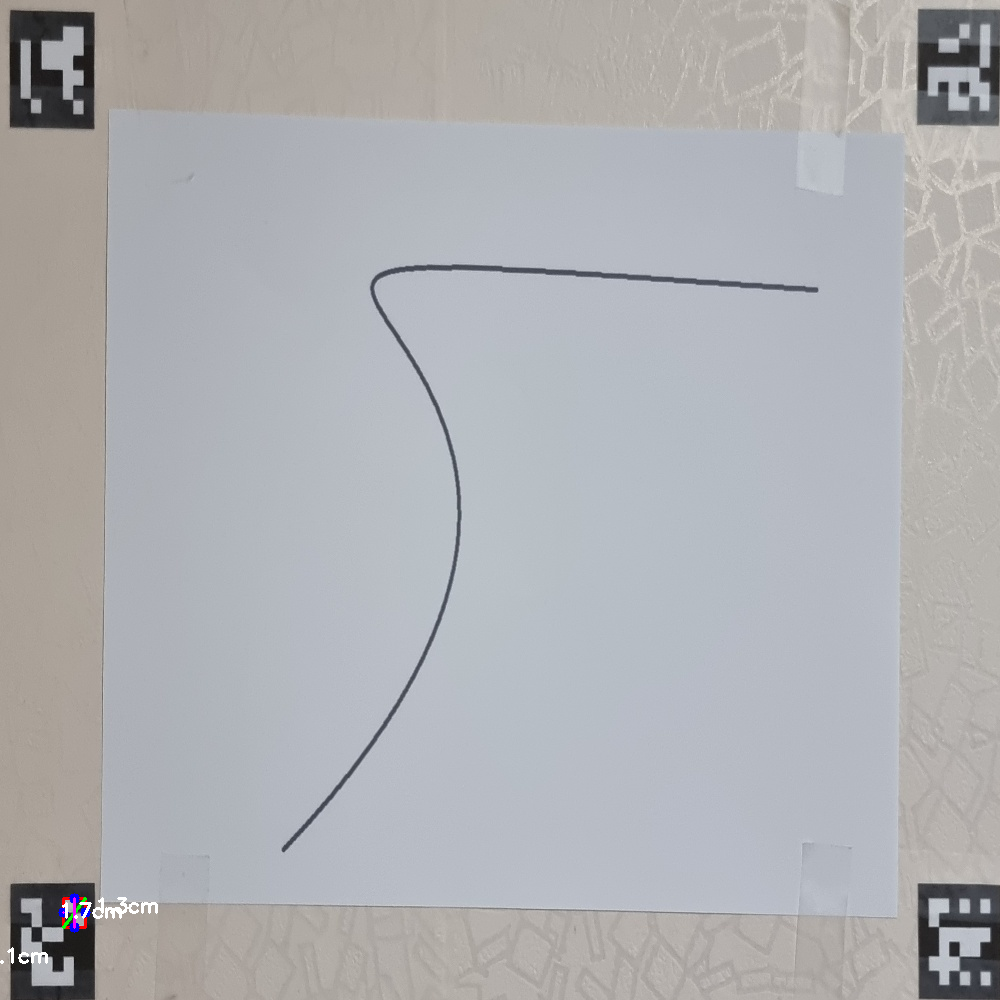

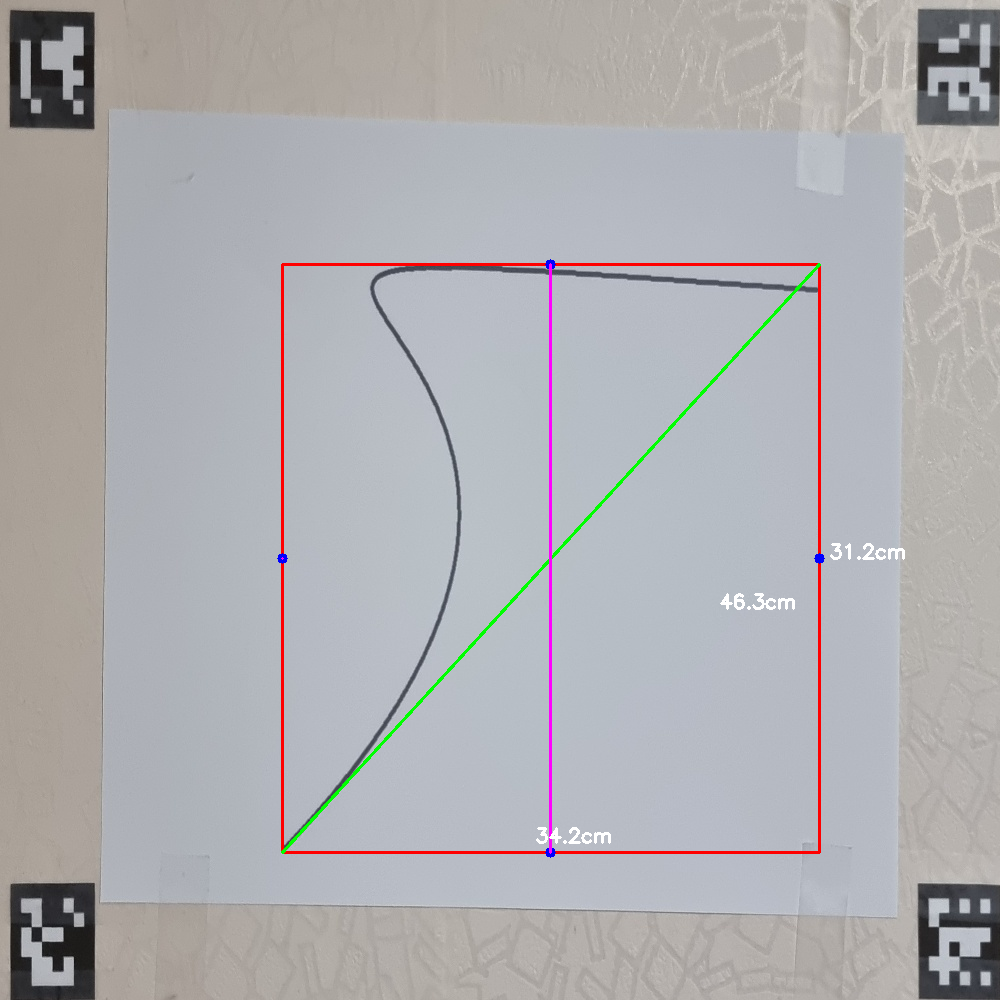

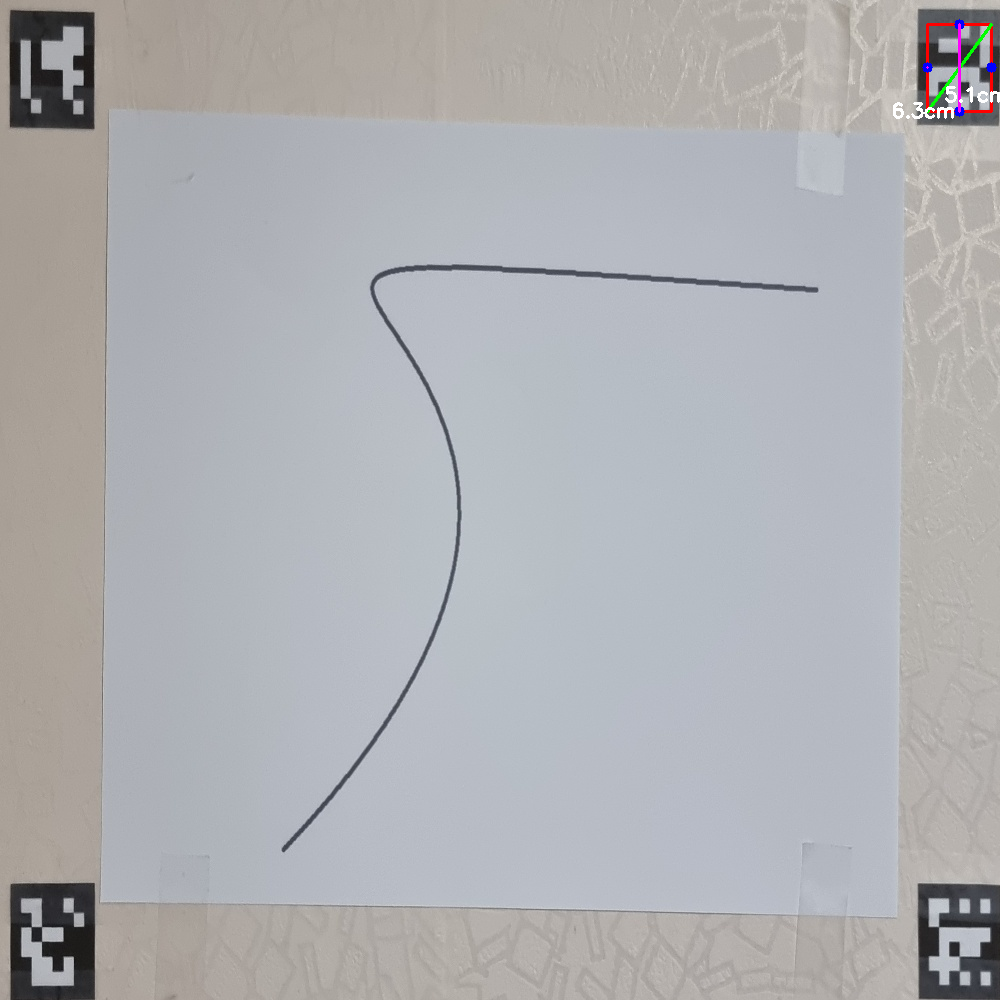

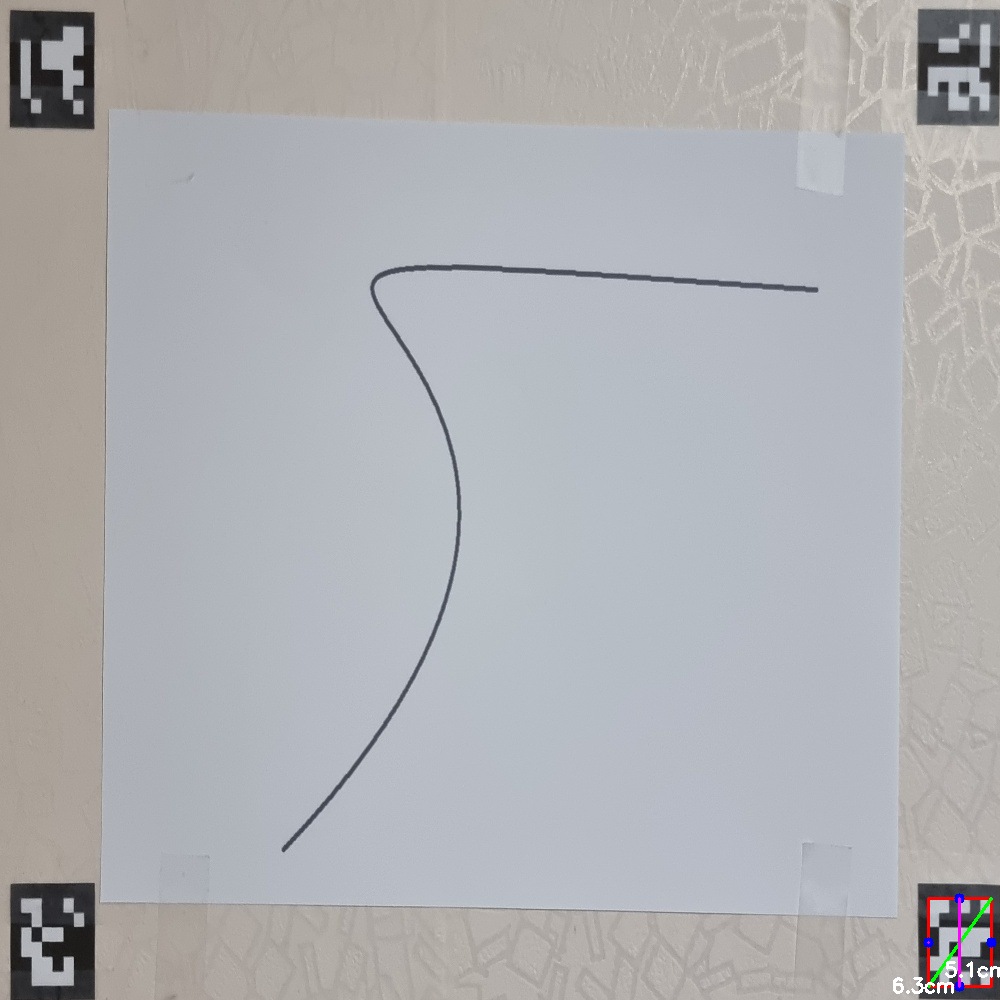

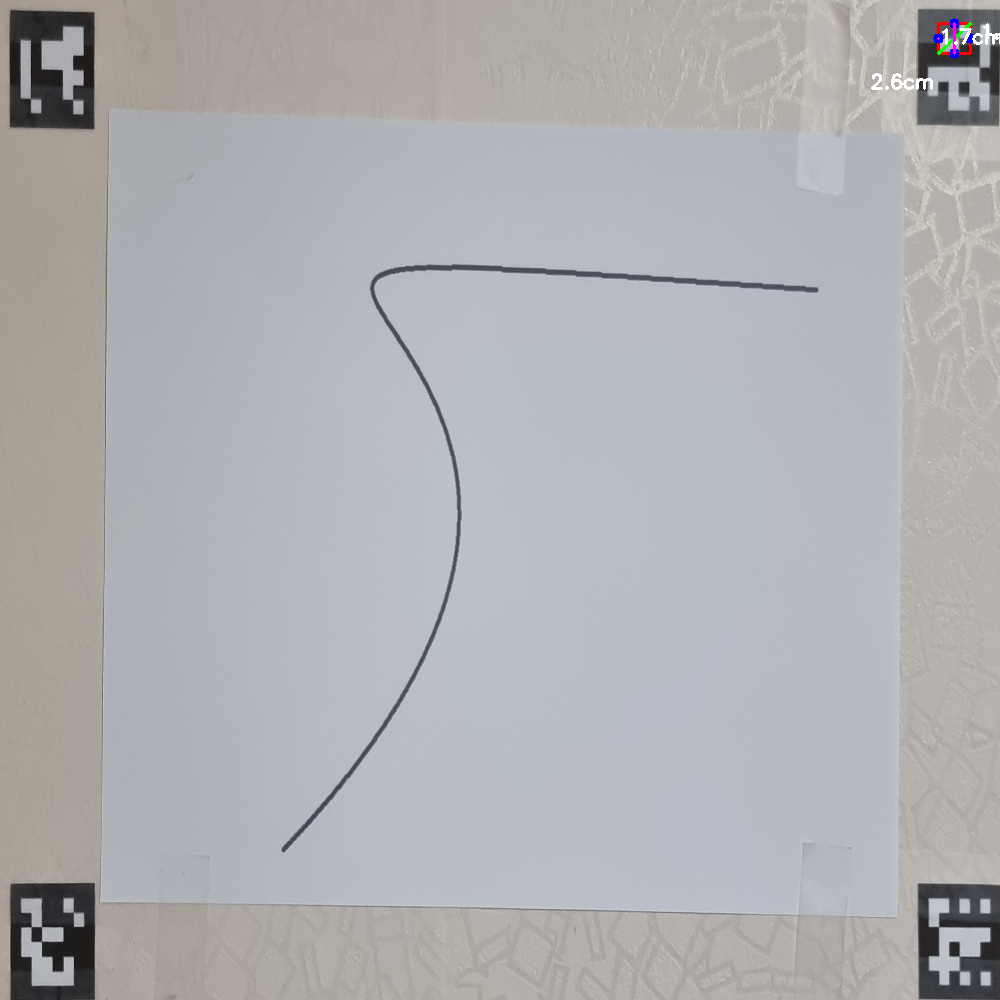

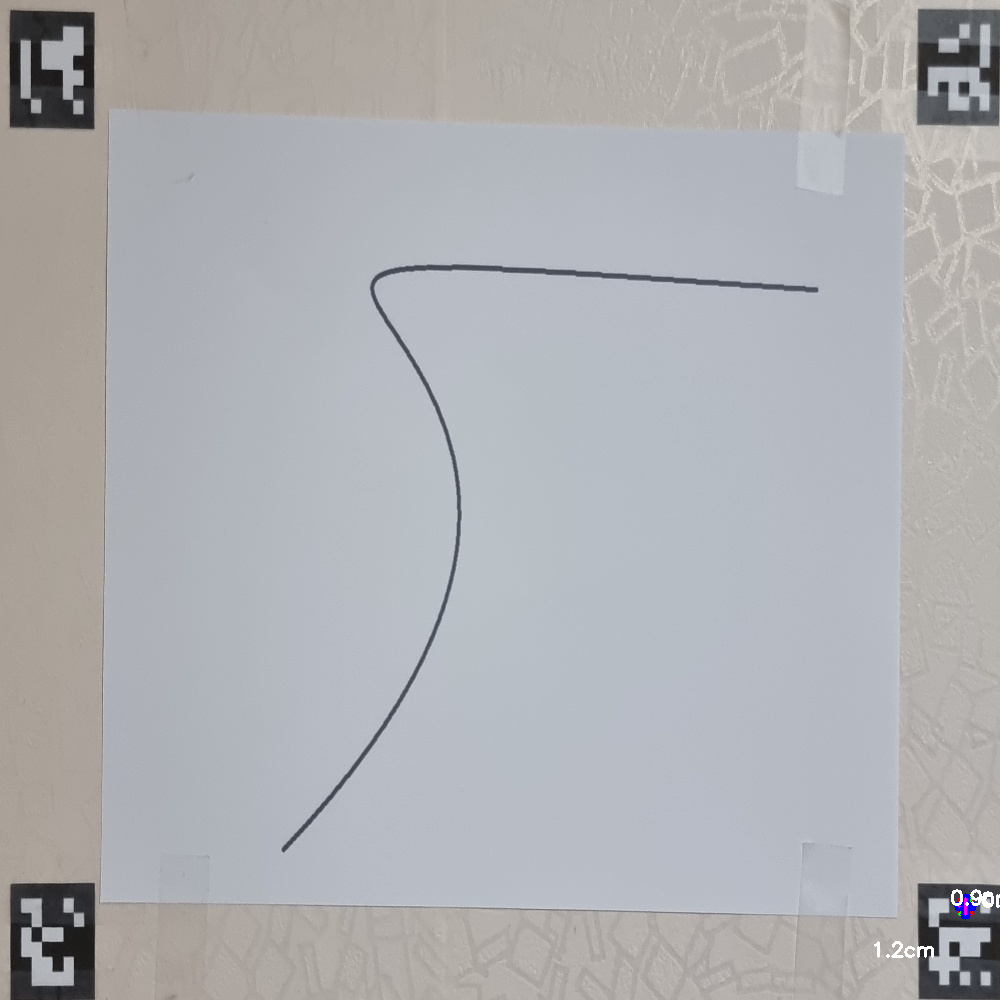

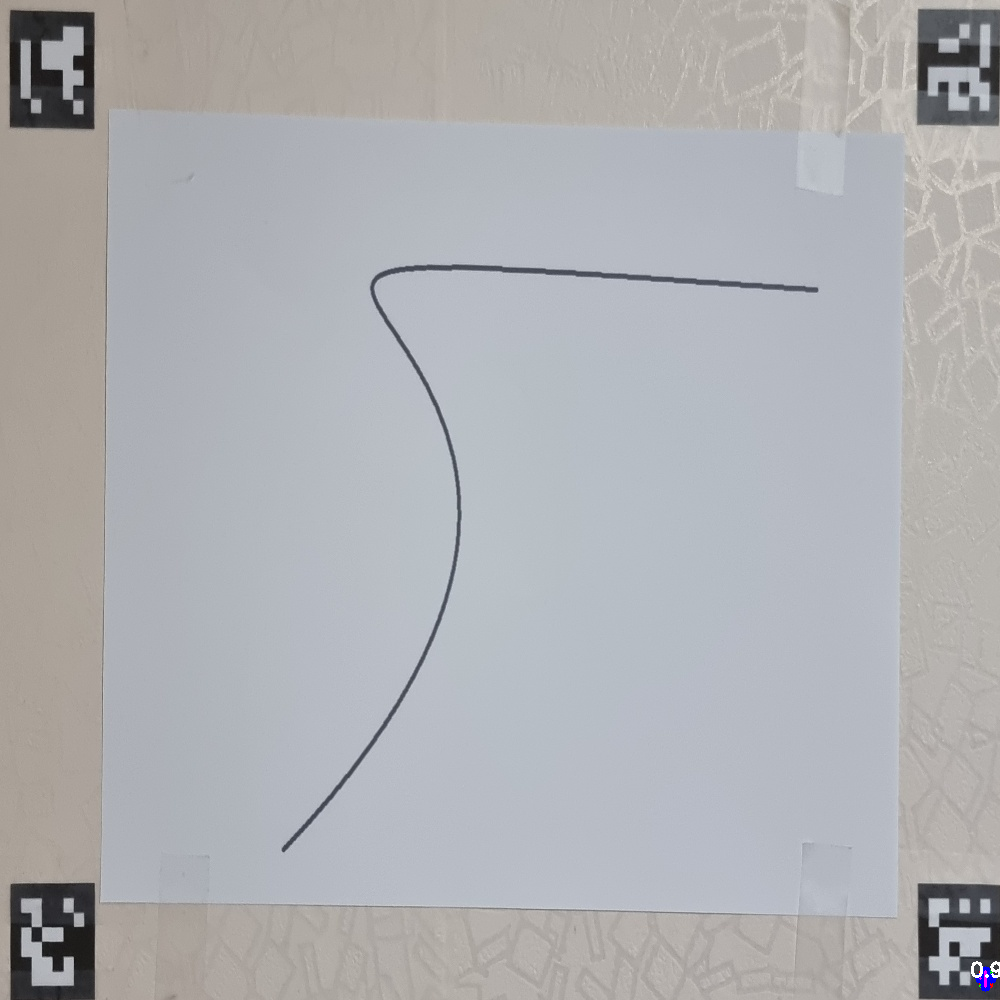

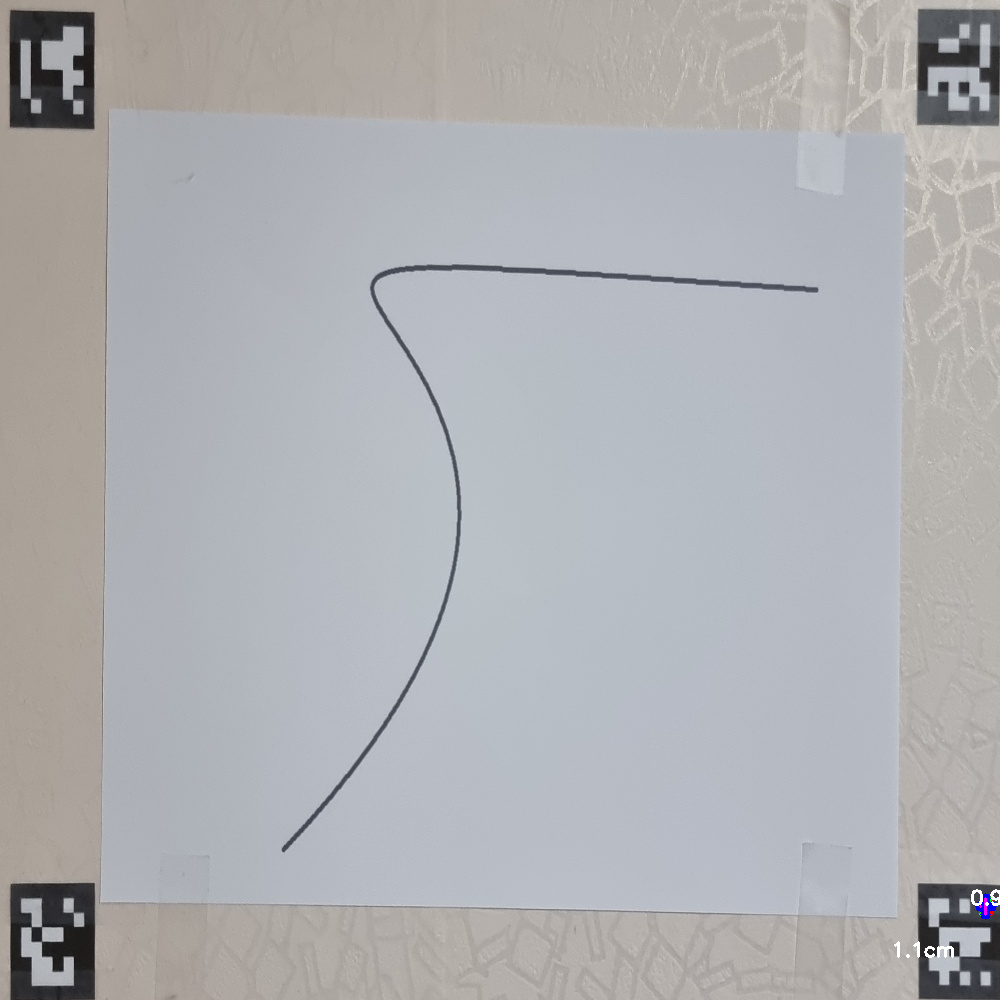

In [90]:
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
from google.colab.patches import cv2_imshow
import numpy as np
import imutils
import cv2

def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

image = cv2.imread('/content/drive/MyDrive/CrackDetection/target.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7,7), 0)

edged = cv2.Canny(gray, 50, 100)
# dilate(img, kernel, iterations)
# img : dilate(팽창) 시킬이미지, kernel: dilate를 위한 커널 iterations : 반복횟수
edged = cv2.dilate(edged, None, iterations=1)
# erode(img,kernel,iterations) 침식
edged = cv2.erode(edged, None, iterations=1)

cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# grab_contours : contour의 총 갯수
cnts = imutils.grab_contours(cnts)

cnts, _ = contours.sort_contours(cnts)
pixelsPerMetric = None

for c in cnts:
  if cv2.contourArea(c) < 100:
    continue
  
  orig = image.copy()
  x,y,w,h = cv2.boundingRect(c)
  bl, br, tr, tl = (x,y+h),(x+w,y+h),(x+w,y),(x,y)
  orig = cv2.rectangle(orig, (x,y), (x+w, y+h), (0,0,255),2)
  line = cv2.line(orig, bl, tr, (0,255,0), 2)
  
  tl, tr, br, bl = (x,y+h),(x+w,y+h),(x+w,y),(x,y)
  (tltrX, tltrY) = midpoint(tl, tr)
  (blbrX, blbrY) = midpoint(bl, br)

  (tlblX, tlblY) = midpoint(tl, bl)
  (trbrX, trbrY) = midpoint(tr, br)

  cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255,0,0), -1)
  cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255,0,0), -1)
  cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255,0,0), -1)
  cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255,0,0), -1)

  cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)), (255,0,255), 2)
  cv2.line(orig, (int(tlblX), int(tlblY)), (int(tlblX), int(trbrY)), (255,0,255), 2)

  dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
  dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
  dC = dist.euclidean(bl,tr)
  if pixelsPerMetric is None:
    pixelsPerMetric = dB / 3.14
  
  dimA = dA / pixelsPerMetric
  dimB = dB / pixelsPerMetric
  dimC = dC / pixelsPerMetric

  cv2.putText(orig, "{:.1f}cm".format(dimA),
		(int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (255, 255, 255), 2)
  cv2.putText(orig, "{:.1f}cm".format(dimB),
		(int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (255, 255, 255), 2)
  cv2.putText(orig, "{:.1f}cm".format(dimC),
		(int(trbrX-100), int(trbrY + 50)), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (255, 255, 255), 2)
  
  cv2_imshow(orig)
  cv2.waitKey(0)

In [ ]:
# dimA dimB의 정보를 가지고 다른 컨투어의 길이를 구하는 방법은 안되는것 같음